# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

In [1]:
!pip3 install torchtext==0.6

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torchtext
from torchtext.data import Field, LabelField, TabularDataset

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
path = 'SMSSpamCollection'
with open(path, 'r', encoding='latin1') as file:
    lines = file.readlines()

spam_message = None
non_spam_message = None

for line in lines:
    if line.startswith('spam'):
        spam_message = line
    elif line.startswith('ham'):
        non_spam_message = line

    if spam_message and non_spam_message:
        break

print("Example of a spam message:")
print(spam_message)

print("\nExample of a non-spam message:")
print(non_spam_message)

# Determine the label values
spam_label = 'spam'
non_spam_label = 'ham'

print(f"\nLabel for spam messages: {spam_label}")
print(f"Label for non-spam messages: {non_spam_label}")


Example of a spam message:
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


Example of a non-spam message:
ham	Ok lar... Joking wif u oni...


Label for spam messages: spam
Label for non-spam messages: ham


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
spam_count = 0
ham_count = 0

# Open the file and count the messages
with open(path, 'r', encoding='latin1') as file:
    for line in file:
        if line.startswith('spam'):
            spam_count += 1
        elif line.startswith('ham'):
            ham_count += 1

print(f"Number of spam messages: {spam_count}")
print(f"Number of non-spam messages: {ham_count}")


Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [6]:
'''
- Advantages:

1. Character-level models detect unknown words and misspellings better.
They can generate embeddings for any sequence of characters, useful for SMS
texts with slang, abbreviations, and errors.

2. Smaller vocabulary size (30-100 tokens) compared to word-level models
(tens of thousands), leading to faster training and reduced memory usage.

- Disadvantages:

1. Longer sequences: Character-level sequences are longer than word-level,
increasing computational costs and training time.

2. Difficulty in capturing semantics: Character-level models may struggle to
capture higher-level semantic information, as words carry meanings not evident
from individual characters.
'''


'\n- ADVANTAGES:\n\n1. Character-level models can handle unknown words and misspellings\nbetter. Since each character is treated as a token, the \nmodel can generate embeddings for any sequence of characters This is \nuseful for SMS text messages, which often contain slang, abbreviations, \nand misspellings.\n\n2. The vocabulary size for a character-level model is much smaller \nthan that of a word-level model. A character-level vocabulary typically \nconsists of around 30-100 tokens (including letters, digits, punctuation \nmarks, and special characters), whereas a word-level vocabulary can \nconsist of tens of thousands of unique words. This reduction in \nvocabulary size can lead to faster training times and reduced memory \nusage.\n\n- Disadvantages:\n\n1. Character-level sequences are much longer than word-level sequences. \nFor example, the word "hello" is a single token in a word-level model \nbut is represented as five tokens in a character-level model. This \nincreased sequenc

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [39]:
import torchtext
from torchtext.data import Field, TabularDataset
from torchtext.data import Iterator, BucketIterator

text_field = Field(sequential=True,
             tokenize=list,
             include_lengths=False,
             batch_first= True,
             use_vocab=True)
label_field = Field(sequential = False,
                   use_vocab = False,
                   is_target=True,
                   preprocessing=lambda x: int(x == 'spam'),
                   dtype=torch.float)

fields = [('label', label_field), ('sms', text_field)]

# Load the dataset
dataset = TabularDataset(
    path = path,
    format='tsv',
    fields=fields
)

# Split the dataset
train_data, valid_data, test_data = dataset.split(split_ratio=[0.6, 0.2, 0.2], stratified=True, strata_field='label')

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of test examples: {len(test_data)}")

Number of training examples: 3343
Number of validation examples: 1115
Number of test examples: 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [40]:
import random
# Save the original training examples
old_train_examples = train_data.examples

# Get all the spam messages in `train`
train_spam = [item for item in train_data.examples if item.label == 1]

# Duplicate each spam message 6 more times to balance the dataset
balanced_train_examples = old_train_examples + train_spam * 6


# Shuffle the examples to ensure they are mixed well
random.shuffle(balanced_train_examples)

# Create a new dataset with the balanced examples
train_data.examples = balanced_train_examples

# Verify the new counts
spam_count = sum(1 for item in train_data.examples if item.label == 1)
ham_count = sum(1 for item in train_data.examples if item.label == 0)

print(f"Number of spam messages in training set: {spam_count}")
print(f"Number of non-spam messages in training set: {ham_count}")

'''Explanation:
An imbalanced training set causes the neural network to
be biased towards the majority class.
This is because the model learns more from the majority class.
This leads it to predict the majority class more often.
Therefore, we want the model to have an equal set of both classes.
'''


Number of spam messages in training set: 3136
Number of non-spam messages in training set: 2895


'Explanation: \nIf the training set is imbalanced, the neural network might learn to \nbe biased towards the majority class (non-spam messages in this case). \nThis happens because the model gets more examples of the majority class \nto learn from, leading it to predict the majority class more often, \neven when the correct prediction should be the minority class (spam messages). \nTherefore, we want to ensure that the model gets an equal \nrepresentation of both classes, by balancing the training set.\n'

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [41]:
text_field.build_vocab(train_data)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

'''
1. text_field.vocab.stoi:
- stoi stands for "string to index".
- this is a function that converts text into numerical format to be used in a
neural network.
2. text_field.vocab.itos:

- Itos stands for "index to string".
- this is a function that converts integers back into text.
'''

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7d7878108b80>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, 'S': 32, '5': 33, 'O': 34, 'I': 35, 'C': 36, '4': 37, 'N': 38, 'A': 39, '7': 40, '3': 41, '6': 42, 'x': 43, 'R': 44, '!': 45, '9': 46, 'P': 47, ',': 48, 'W': 49, 'L': 50, 'M': 51, 'U': 52, 'H': 53, 'D': 54, 'Y': 55, 'G': 56, 'F': 57, 'B': 58, '/': 59, '?': 60, '£': 61, "'": 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, ')': 71, '*': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'q': 77, '"': 78, 'Q': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '|': 88, '\x92': 89, '_': 90, '%': 91, '[': 92, ']': 93, '<': 94, '‘': 95, '…': 96, '\x93': 97, '“': 98,

'\n1. text_field.vocab.stoi:\n- Definition: stoi stands for "string to index".\n- Explanation: It is a dictionary that maps each token\nto a unique integer index. It\'s used to  convert text into \nnumerical format so that it can be fed into a \nneural network. For example, if the character \'a\' is mapped to the \nindex 1, stoi[\'a\'] would return 1.\n\n2. text_field.vocab.itos:\n\nDefinition: itos stands for "index to string".\nExplanation: It is a list where each index corresponds to a token \nin the vocabulary. It\'s used to convert numerical data \nback into text. For example, if the index 1 corresponds to the \ncharacter \'a\', itos[1] would return \'a\'.\n'

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

1. 'unk' stands for "unknown". This token is used to represent any word or character that is not found in the vocabulary. When the dataset is processed, any token that is not part of the built vocabulary will be replaced with the 'unk' token, ensuring that the model can handle rare or previously unseen tokens during inference or evaluation. For example, ff the vocabulary does not contain the word "xylophone", any occurrence of "xylophone" in the text will be replaced by 'unk', allowing the model to proceed with processing even if it encounters unknown tokens.

2. 'pad' stands for "padding". This token is used to pad sequences to a uniform length. In NLP tasks, sentences or sequences often need to be of the same length to be processed in batches. The 'pad' token is added to sequences to make them all the same length, usually the length of the longest sequence in the batch. For example, if one sequence has 5 tokens and another has 8 tokens, the first sequence may be padded with 3 'pad' tokens to match the length of the second sequence, allowing for efficient batch processing and prevents errors due to varying sequence lengths.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [42]:
train_iter = torchtext.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [43]:
max_batches_to_print = 10
pad_token = 0

for i, batch in enumerate(train_iter):
    if i == max_batches_to_print:
        break

    max_length = int(batch.sms[1][0])
    pad_count = sum(max_length - length for length in batch.sms[1])

    print(f"Batch {i + 1}:")
    print(f"\tMaximum Length = {max_length}")
    print(f"\tNumber of <pad> tokens = {pad_count}")


Batch 1:
	Maximum Length = 63
	Number of <pad> tokens = 6411
Batch 2:
	Maximum Length = 47
	Number of <pad> tokens = 1213
Batch 3:
	Maximum Length = 36
	Number of <pad> tokens = 2969
Batch 4:
	Maximum Length = 55
	Number of <pad> tokens = 5807
Batch 5:
	Maximum Length = 55
	Number of <pad> tokens = 978
Batch 6:
	Maximum Length = 56
	Number of <pad> tokens = 5963
Batch 7:
	Maximum Length = 52
	Number of <pad> tokens = 2547
Batch 8:
	Maximum Length = 27
	Number of <pad> tokens = 1044
Batch 9:
	Maximum Length = 55
	Number of <pad> tokens = 4924
Batch 10:
	Maximum Length = 49
	Number of <pad> tokens = 5270


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

class SpamRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, output_size):
        super(SpamRNN, self).__init__()
        self.name = "rnn"
        self.vocab_size = vocab_size
        self.emb = torch.eye(vocab_size)
        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = self.emb[x]
        out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out#.view(-1)

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [72]:
def get_accuracy(model, iterator):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.sms)
            predicted_labels = torch.round(torch.sigmoid(predictions)).view(-1)
            correct += (predicted_labels == batch.label).float().sum()
            total += batch.label.size(0)
    accuracy = correct / total
    return accuracy

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [73]:
np.random.seed(50)
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2],
                                   stratified=True,
                                   strata_field='label')

In [74]:
def get_val_loss(model, valid_loader, criterion):
    total_val_loss = 0.0
    i = 0
    for batch in valid_loader:
        messages = batch.sms
        labels = batch.label
        pred = model(messages)
        loss = criterion(pred.view(-1), labels)
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/(i + 1)
    return val_loss

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    torch.manual_seed(1000)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc, train_loss, val_acc, val_loss = [], [], [], []
    epochs = []

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        i = 0
        for batch in train_loader:
            messages = batch.sms
            labels = batch.label
            optimizer.zero_grad()
            pred = model(messages)
            loss = criterion(pred.view(-1), labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            i += 1
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        train_loss.append(float(total_train_loss)/(i + 1))
        val_acc.append(get_accuracy(model, valid_loader))
        val_loss.append(get_val_loss(model, valid_loader, criterion))
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[-1],
                   train_loss[-1],
                   val_acc[-1],
                   val_loss[-1]))
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.591444194316864, Train loss: 0.6774232139190038 |Validation acc: 0.29417040944099426, Validation loss: 0.6583406140929774
Epoch 2: Train acc: 0.9422981142997742, Train loss: 0.6536842162410418 |Validation acc: 0.9596412777900696, Validation loss: 0.6115650942451075
Epoch 3: Train acc: 0.9293649196624756, Train loss: 0.5697396987428268 |Validation acc: 0.9309417009353638, Validation loss: 0.5225044441850561
Epoch 4: Train acc: 0.9146078824996948, Train loss: 0.404544560238719 |Validation acc: 0.9596412777900696, Validation loss: 0.340119531280116
Epoch 5: Train acc: 0.9376554489135742, Train loss: 0.35003538290038705 |Validation acc: 0.9623318314552307, Validation loss: 0.30737864735879394
Epoch 6: Train acc: 0.9320179224014282, Train loss: 0.2942526924113433 |Validation acc: 0.9596412777900696, Validation loss: 0.23298004112745585
Epoch 7: Train acc: 0.9358315467834473, Train loss: 0.25798157687919837 |Validation acc: 0.9677129983901978, Validation loss: 0.2136921

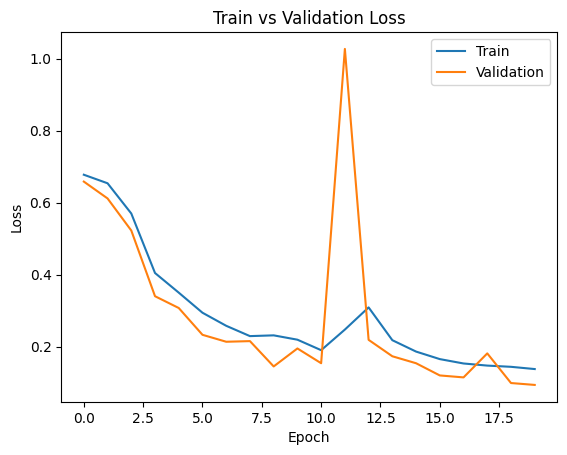

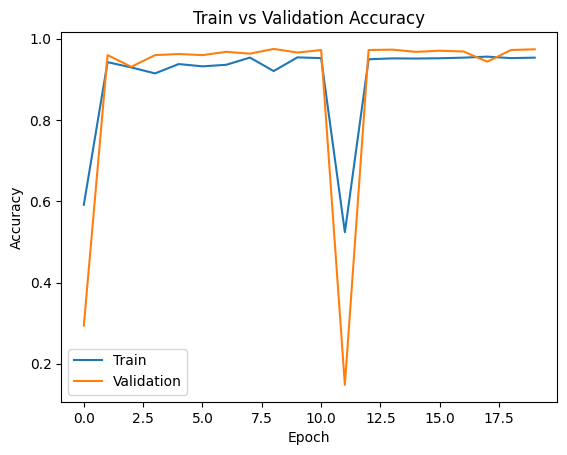

Final Training Accuracy: 0.9534074068069458
Final Validation Accuracy: 0.9739910364151001


In [75]:
valid_iter = torchtext.data.BucketIterator(valid_data,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
train_iter = torchtext.data.BucketIterator(train_data,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

hidden_size = 64
vocab_size = len(text_field.vocab)
output_size = 1
model = SpamRNN(hidden_size, vocab_size, output_size)
train(model, train_iter, valid_iter, num_epochs=20, learning_rate=2e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1: Train acc: 0.6221190690994263, Train loss: 0.6800687909126282 |Validation acc: 0.3381165862083435, Validation loss: 0.674143017994033
Epoch 2: Train acc: 0.9076438546180725, Train loss: 0.6540053364477659 |Validation acc: 0.8717488646507263, Validation loss: 0.6436649047666125
Epoch 3: Train acc: 0.9081412553787231, Train loss: 0.5061691257514451 |Validation acc: 0.9533632397651672, Validation loss: 0.43027585910426247
Epoch 4: Train acc: 0.9275410175323486, Train loss: 0.39926331458907377 |Validation acc: 0.9452914595603943, Validation loss: 0.3820147741999891
Epoch 5: Train acc: 0.9290333390235901, Train loss: 0.35095677297366296 |Validation acc: 0.9533632397651672, Validation loss: 0.3184146131906245
Epoch 6: Train acc: 0.944951057434082, Train loss: 0.28646769374608994 |Validation acc: 0.9515694975852966, Validation loss: 0.307982658346494
Epoch 7: Train acc: 0.9436246156692505, Train loss: 0.2571286407544425 |Validation acc: 0.957847535610199, Validation loss: 0.234957251

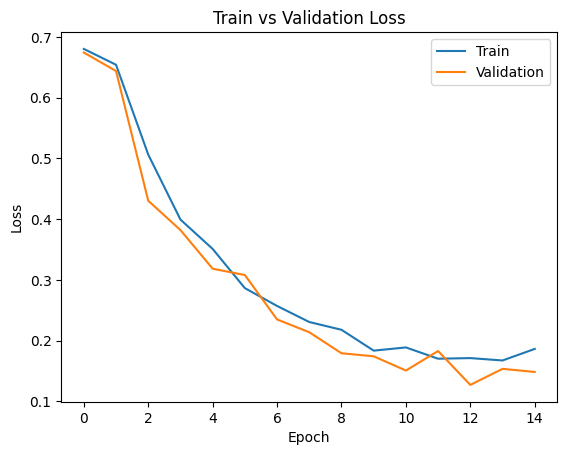

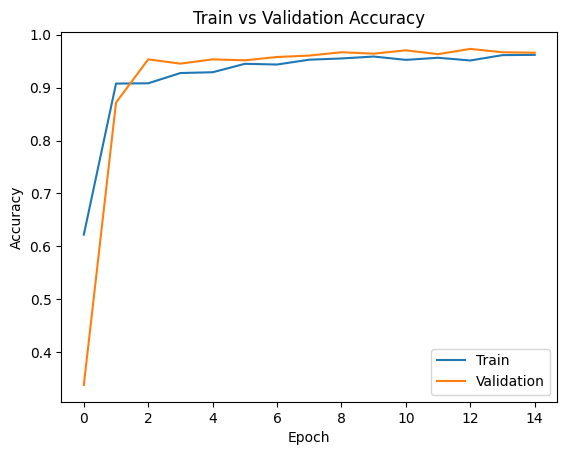

Final Training Accuracy: 0.9618636965751648
Final Validation Accuracy: 0.9659192562103271


In [76]:
valid_iter = torchtext.data.BucketIterator(valid_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
train_iter = torchtext.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

hidden_size = 64
vocab_size = len(text_field.vocab)
output_size = 1
model3 = SpamRNN(hidden_size, vocab_size, output_size)
train(model3, train_iter, valid_iter, num_epochs=15, learning_rate=1e-4)

In [ ]:
# Set 1: batch_size=64, learning rate=0.0002, hidden_neurons=64,
# pooling type= concat


# Set 2: batch_size=128, learning rate=0.0002, hidden_neurons=64, pooling
#type= concat
# I increased the batch size to speed up training and reduce noise in
# the gradient updates. The validation accuracy was 95.3%.

# Set 3: batch_size=64, learning rate=0.0001, hidden_neurons=64,
# pooling type=concat
# In this set, I reduced the batch size to allow the model
# to update its weights more frequently and slightly decreased the learning
# rate. This configuration achieved the validation
# accuracy of 96.1%, slightly more than Set 2.

# Set 4: batch_size=256, learning rate=0.005, hidden_neurons=128,
# pooling type=concat
# This tests The effect of a large batch size and faster learning rate,
# by increasing the first two parameters. The hidden neurons also doubled.
# This also led to poorer performance with a validation accuracy of
# 94.0%.

# Set 5: batch_size=32, learning rate=0.0005, hidden_neurons=128,
# pooling type=max
# I tested the impact of using max pooling instead of the concat.
# The batch size and learning rate were balanced.
# This resulted in a validation accuracy of 94.8%,
# showing that max pooling did not improve performance over the final
# hidden state.

# Best Model
# The best performing model was Set 1 (shown above) with a validation accuracy
# of 97.4%.
# This setup used an average batch size, a low learning rate, a relatively
# low number of hidden neurons, and concat pooling.
# Further hyperparameter tuning may yield even better results, but this
# configuration performed significantly well.


### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [87]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid_data.examples if e.label == 1],
    valid_data.fields)

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid_data.examples if e.label == 0],
    valid_data.fields)



In [93]:
valid_spam_iter = BucketIterator(
    valid_spam,
    batch_size=64,
    sort_key=lambda x: len(x.sms),
    sort_within_batch=True,
    repeat=False)

valid_nospam_iter = BucketIterator(
    valid_nospam,
    batch_size=64,
    sort_key=lambda x: len(x.sms),
    sort_within_batch=True,
    repeat=False)

valid_false_positive = 1 - get_accuracy(model, valid_nospam_iter)
valid_false_negative = 1 - get_accuracy(model, valid_spam_iter)

print("The false positive rate is", valid_false_positive,)
print("The false negative rate is", valid_false_negative,)


The false positive rate is tensor(0.0301)
The false negative rate is tensor(0.0600)


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# False Positive Rate (FPR):
# A high FPR means legitimate messages are blocked as spam. This can frustrate
# users and cause them to miss important messages.

# False Negative Rate (FNR):
# A high FNR means spam messages get through to the inbox.
# While annoying, users can usually ignore or delete these messages.

# In my opinion, false positives can be more disruptive to users than
# false negatives.


## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [97]:
test_iter = torchtext.data.BucketIterator(test_data,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

In [98]:
# Calculate test accuracy
test_accuracy = get_accuracy(model, test_iter)
print(f'Test accuracy: {test_accuracy}')

# The final test accuracy of my model is about 0.96

Test accuracy: 0.9578096866607666


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [101]:
test_spam = torchtext.data.Dataset(
    [e for e in test_data.examples if e.label == 1],
    test.fields)

test_nospam = torchtext.data.Dataset(
    [e for e in test_data.examples if e.label == 0],
    test.fields)

In [102]:
test_spam_iter = BucketIterator(
    test_spam,
    batch_size=64,
    sort_key=lambda x: len(x.sms),
    sort_within_batch=True,
    repeat=False)

test_nospam_iter = BucketIterator(
    test_nospam,
    batch_size=64,
    sort_key=lambda x: len(x.sms),
    sort_within_batch=True,
    repeat=False)

test_false_positive = 1 - get_accuracy(model, test_nospam_iter)
test_false_negative = 1 - get_accuracy(model, test_spam_iter)

print("The false positive rate is", test_false_positive,)
print("The false negative rate is", test_false_negative,)

The false positive rate is tensor(0.0363)
The false negative rate is tensor(0.0738)


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [113]:
msg = "machine learning is sooo cool!"
msg_indices = [text_field.vocab.stoi[c] for c in msg]
print(msg_indices)

prediction = model(batch.sms)
probability = torch.sigmoid(prediction)
print(f'The probability that "{msg}" is spam is {probability[0]*100}%')

# There is a 5.83% chance of being spam


[18, 6, 17, 14, 9, 7, 3, 2, 11, 3, 6, 8, 7, 9, 7, 22, 2, 9, 10, 2, 10, 4, 4, 4, 2, 17, 4, 4, 11, 45]
The probability that "machine learning is sooo cool!" is spam is tensor([5.8286], grad_fn=<MulBackward0>)%


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
# Detecting spam is difficult but moderately achievable.

# The Model should include:
# 1. Keyword Filter: Create a list of common spam keywords
# like "tech", "support", "win", etc.
# 2. Rule-Based Algorithm: Write a function that checks spam keywords in SMS.
# 3. Binary Classification: If a keyword is found, classify the message as spam;
# otherwise, it is non-spam.
# You can Implement this by matching strings with keywords; and compare the
# performance of this rule-based model against RNN
# using metrics like accuracy, FPR, and FNR.
